In [20]:
import numpy as np
import pandas as pd
from PIL import Image
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, silhouette_score
import os
import cv2
import matplotlib.pyplot as plt


In [21]:
# Fungsi untuk memuat gambar dari folder dan mengekstraksi label dari CSV
def load_images_and_labels(folder, csv_path):
    df = pd.read_csv(csv_path)
    images = []
    labels = []
    for _, row in df.iterrows():
        img_path = os.path.join(folder, row['image'])
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (150, 150))  # Resize gambar
            images.append(img)
            labels.append(row['label'])
    return np.array(images), np.array(labels)

In [22]:
# Fungsi untuk mengekstraksi fitur dari gambar
def extract_features(images):
    n_samples = len(images)
    data = images.reshape((n_samples, -1))
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)
    pca = PCA(n_components=50)
    data_pca = pca.fit_transform(data_scaled)
    return data_pca, scaler, pca

In [24]:
# Fungsi untuk melakukan K-means clustering
def kmeans_clustering(features, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(features)
    return kmeans

In [25]:
# Fungsi untuk membuat pemetaan cluster ke label
def map_clusters_to_labels(kmeans, true_labels):
    cluster_to_labels = {}
    for cluster in range(kmeans.n_clusters):
        labels_in_cluster = true_labels[kmeans.labels_ == cluster]
        if len(labels_in_cluster) > 0:
            most_common_label = np.bincount(labels_in_cluster).argmax()
            cluster_to_labels[cluster] = most_common_label
    return cluster_to_labels

In [26]:
# Fungsi untuk memprediksi label berdasarkan klaster
def predict_with_kmeans(kmeans, features, cluster_to_labels):
    cluster_labels = kmeans.predict(features)
    predicted_labels = [cluster_to_labels[cluster] for cluster in cluster_labels]
    return np.array(predicted_labels)

In [28]:
# Memuat dataset gambar dan label
folder_path = 'D:/Users/natan/Skripsi/Dataset/Images_dataset/'
csv_path = 'D:/Users/natan/Skripsi/Dataset/Images_dataset/english.csv'
images, labels = load_images_and_labels(folder_path, csv_path)

In [29]:
# Encode label string menjadi integer
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

In [30]:
# Ekstraksi fitur
features, scaler, pca = extract_features(images)

In [31]:
# K-means clustering
num_clusters = len(np.unique(labels))
kmeans = kmeans_clustering(features, num_clusters)

In [32]:
# Membuat pemetaan cluster ke label
cluster_to_labels = map_clusters_to_labels(kmeans, labels_encoded)

In [33]:
# Memetakan kembali dari integer ke label asli
cluster_to_labels_str = {cluster: label_encoder.inverse_transform([label])[0] for cluster, label in cluster_to_labels.items()}

In [34]:
# Prediksi menggunakan K-means clustering
predicted_labels_encoded = predict_with_kmeans(kmeans, features, cluster_to_labels)
predicted_labels = label_encoder.inverse_transform(predicted_labels_encoded)

In [36]:
# Menghitung akurasi
accuracy = accuracy_score(labels, predicted_labels)
print(f"Akurasi K-Means clustering: {accuracy * 100:.2f}%")

Akurasi K-Means clustering: 11.47%


In [37]:
# Mengukur silhouette score
silhouette_avg = silhouette_score(features, kmeans.labels_)
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.04348576297437443


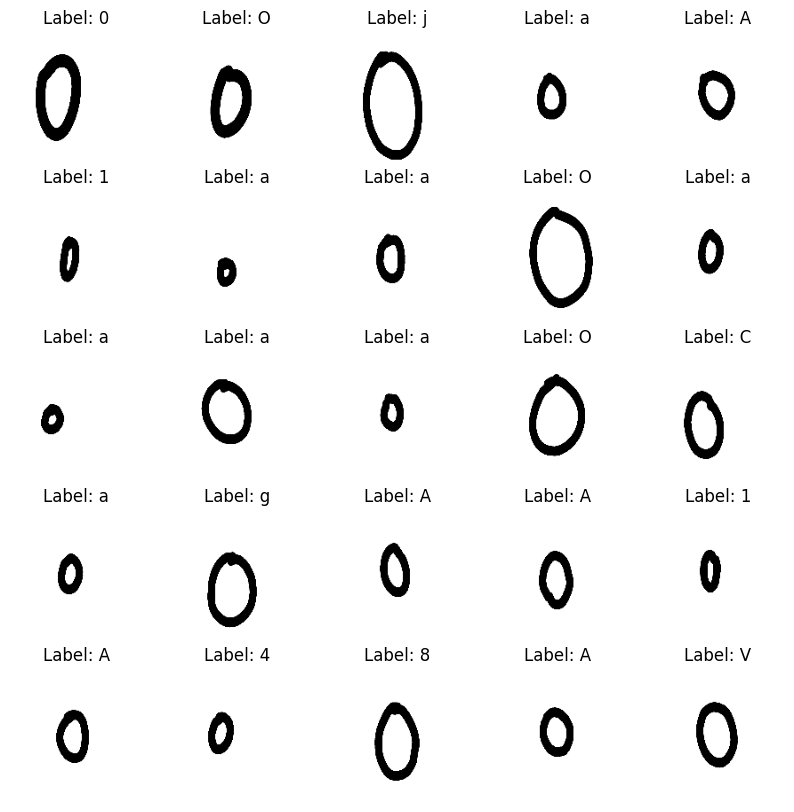

In [38]:
# Fungsi untuk visualisasi gambar dan label prediksi
def plot_images(images, labels, nrows, ncols):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i], cmap='gray')
        label = labels[i]
        ax.set_title(f'Label: {label}')
        ax.axis('off')
    plt.show()

# Visualisasi beberapa hasil clustering
plot_images(images, predicted_labels, 5, 5)

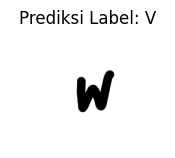

In [41]:
from tensorflow.keras.preprocessing import image

# Meminta pengguna memasukkan path file
path = input("Masukkan path file gambar: ")

# Memproses gambar
img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
if img is not None:
    img = cv2.resize(img, (150, 150))  # Resize gambar
    plt.figure(figsize=(2, 2))
    img = img.reshape(1, -1)  # Ratakan gambar
    img_scaled = scaler.transform(img)  # Normalisasi
    img_pca = pca.transform(img_scaled)  # Transformasi PCA

    # Prediksi label menggunakan K-means clustering
    cluster_label = kmeans.predict(img_pca)
    predicted_label = cluster_to_labels_str[cluster_label[0]]

    # Tampilkan gambar dan hasil prediksi
    plt.imshow(cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB))
    plt.title(f'Prediksi Label: {predicted_label}')
    plt.axis('off')
    plt.show()